# Build Random Forest Model

In [1]:
# Cheers again to Brunna Torino for their great analysis of real estate prices in Amsterdam 
# (https://towardsdatascience.com/ai-and-real-state-renting-in-amsterdam-part-1-5fce18238dbc)
# The ideas have been repurposed here to deal with the Washington, DC real estate market!

In [1]:
import numpy as np
import pandas as pd

apts = pd.read_csv('ApartmentList_Cleaned_Full.csv')
apts_ml = apts[['apt_rent', 'apt_footage', 'rooms', 'distance_wh', 'distance_cap', 'building_units_available',
               'adj_open', 'adj_large', 'adj_private', 'adj_great', 'adj_new', 'adj_beautiful', 'adj_high', 'adj_natural',
               'adj_historic', 'adj_newly', 'adj_short', 'adj_ready', 'adj_furnished', 'adj_convenient', 'adj_windows']]

In [18]:
 # Remove the two rows where apt_rent was still 0 (apartments with 10 and 11 bedrooms)
apts_ml = apts_ml[apts_ml['apt_rent'] != 0]

In [19]:
target= np.array(apts_ml['apt_rent'])
features = apts_ml.drop('apt_rent', axis = 1)
feature_list = list(features.columns)
features = np.array(features)

In [23]:
## RANDOM FOREST - KFOLD AND MODEL 


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
    
kf = KFold(n_splits=10, shuffle=True)
accuracies = []
for train_index, test_index in kf.split(features):

    data_train   = features[train_index]
    target_train = target[train_index]

    data_test    = features[test_index]
    target_test  = target[test_index]

    rf = RandomForestRegressor(n_estimators = 1000, 
                               criterion = 'mse',
                               bootstrap=True)
    
    rf.fit(data_train, target_train)

    predictions = rf.predict(data_test)

    errors = abs(predictions - target_test)

    print('Mean Absolute Error:', round(np.mean(errors), 2))
    
    mape = 100 * (errors / target_test)
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print('Average accuracy:', average_accuracy)

Mean Absolute Error: 370.1
Accuracy: 88.4 %.
Mean Absolute Error: 270.51
Accuracy: 89.47 %.
Mean Absolute Error: 272.3
Accuracy: 89.63 %.
Mean Absolute Error: 336.65
Accuracy: 87.93 %.
Mean Absolute Error: 350.71
Accuracy: 87.87 %.
Mean Absolute Error: 259.46
Accuracy: 90.22 %.
Mean Absolute Error: 372.86
Accuracy: 88.44 %.
Mean Absolute Error: 329.09
Accuracy: 87.67 %.
Mean Absolute Error: 356.39
Accuracy: 87.09 %.
Mean Absolute Error: 396.05
Accuracy: 85.48 %.
Average accuracy: 88.22103844673418


In [24]:
# That was alright - look at average accuracy of ~88.2. Let's do some hyperparameter tuning to get more accurate models

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [25]:
# Return the best parameters
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(data_train, target_train)

print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.3min finished


{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}


In [26]:
# Ok now let's include best parameters in the model
# Best parameters from above: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}

## RANDOM FOREST - KFOLD AND MODEL 


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
    
kf = KFold(n_splits=10,random_state=42,shuffle=True)
accuracies = []
for train_index, test_index in kf.split(features):

    data_train   = features[train_index]
    target_train = target[train_index]

    data_test    = features[test_index]
    target_test  = target[test_index]

    rf = RandomForestRegressor(n_estimators = 200, 
                               random_state = 42, 
                               criterion = 'mse',
                               min_samples_leaf = 1,
                               min_samples_split= 2,
                               max_features = 'sqrt',
                               bootstrap=True,
                               max_depth = 50)
    
    rf.fit(data_train, target_train)

    predictions = rf.predict(data_test)

    errors = abs(predictions - target_test)

    print('Mean Absolute Error:', round(np.mean(errors), 2))
    
    mape = 100 * (errors / target_test)
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print('Average accuracy:', average_accuracy)


Mean Absolute Error: 354.78
Accuracy: 87.31 %.
Mean Absolute Error: 394.37
Accuracy: 84.4 %.
Mean Absolute Error: 360.24
Accuracy: 86.83 %.
Mean Absolute Error: 316.27
Accuracy: 88.18 %.
Mean Absolute Error: 372.18
Accuracy: 87.26 %.
Mean Absolute Error: 338.9
Accuracy: 88.1 %.
Mean Absolute Error: 340.74
Accuracy: 86.26 %.
Mean Absolute Error: 397.08
Accuracy: 85.76 %.
Mean Absolute Error: 391.36
Accuracy: 86.7 %.
Mean Absolute Error: 349.97
Accuracy: 87.07 %.
Average accuracy: 86.78790777518864


In [27]:
# Ok, that bumped average accuracy up to 86.7%, which is definitely better. Now let's save that tree and see what itlooks like!
## SAVING THE DECISION TREE 

from sklearn.tree import export_graphviz
import pydot
tree = rf.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

# Now let's take a look at feature importance
y = rf.feature_importances_
list_y = [a for a in y if a > 0.005]
print(list_y)

list_of_index = []
for i in list_y:
    a = np.where(y==i)
    list_of_index.append(a)
print(list_of_index)

[0.36873643095861935, 0.2596685572830047, 0.12583124555812933, 0.12551905682764444, 0.03299349540132837, 0.010862044972604793, 0.005520185200441033, 0.011333783357575402, 0.01088870692301239, 0.0067915641521334585, 0.006094640888575144, 0.009556393417439949]
[(array([0], dtype=int64),), (array([1], dtype=int64),), (array([2], dtype=int64),), (array([3], dtype=int64),), (array([4], dtype=int64),), (array([5], dtype=int64),), (array([6], dtype=int64),), (array([9], dtype=int64),), (array([10], dtype=int64),), (array([11], dtype=int64),), (array([13], dtype=int64),), (array([17], dtype=int64),)]


In [56]:
# We also want to know which features were most important to the decisions

# Get it in right format and add labels
list_of_index = [0,1,2,3,4]
col = []
for i in feature_list:
    col.append(i)
labels = []
for i in list_of_index:
    b = col[i]
    labels.append(b)

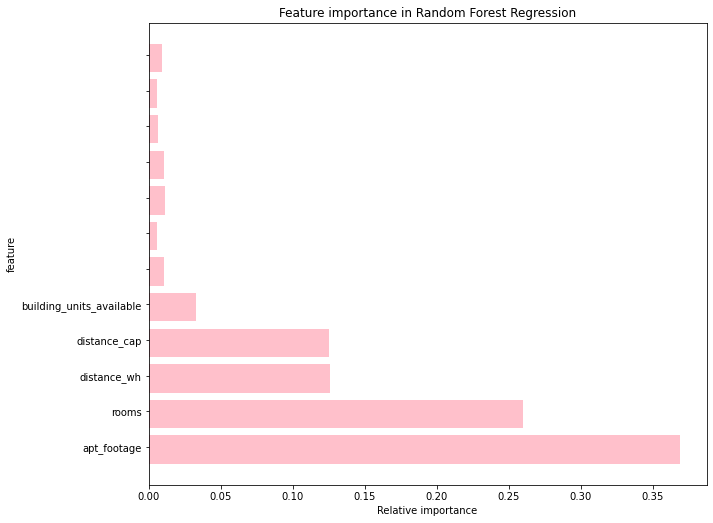

<Figure size 720x612 with 0 Axes>

In [57]:
# Plot most important features
import matplotlib.pyplot as plt
y = list_y
fig, ax = plt.subplots() 
width = 0.8
ind = np.arange(len(y)) 
ax.barh(ind, y,width, color="pink")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(labels, minor=False)
plt.title('Feature importance in Random Forest Regression')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(10,8.5))
fig.set_size_inches(10, 8.5, forward=True)

In [58]:
apts_ml.to_csv('ApartmentList_ML.csv', index = False)
apts_ml

apt_rent  apt_footage  rooms  distance_wh  distance_cap  \
0         1427          456      1          933          2966   
1         1677          610      2          933          2966   
2         2078          762      2         5893          7877   
3         2876         1182      3         5893          7877   
4         2078          762      2         5893          7877   
...        ...          ...    ...          ...           ...   
1992      1311          480      1         1706          1734   
1993      1651          719      2         1706          1734   
1994      3135         1140      3         1706          1734   
1995      2200          575      2         4547          2063   
1996     10000         2636      6         2359          3046   

      building_units_available  adj_open  adj_large  adj_private  adj_great  \
0                           52         0          0            0          0   
1                           52         0          0            0          0   
2                           13         1          0            0          0   
3                           13         1          0            0          0   
4                           13         1          0            0          0   
...                        ...       ...        ...          ...        ...   
1992                         1         0          0            0          0   
1993                         1         0          0            0          0   
1994                         1         0          0            0          0   
1995                         1         1          0            0          0   
1996                         1         0          0            0          0   

      ...  adj_beautiful  adj_high  adj_natural  adj_historic  adj_newly  \
0     ...              0         0            0             0          0   
1     ...              0         0            0             0          0   
2     ...              1         0            0             0          0   
3     ...              1         0            0             0          0   
4     ...              1         0            0             0          0   
...   ...            ...       ...          ...           ...        ...   
1992  ...              0         0            0             0          0   
1993  ...              0         0            0             0          0   
1994  ...              0         0            0             0          0   
1995  ...              1         0            1             0          0   
1996  ...              0         0            0             0          0   

      adj_short  adj_ready  adj_furnished  adj_convenient  adj_windows  
0             0          0              0               0            0  
1             0          0              0               0            0  
2             0          0              0               0            0  
3             0          0              0               0            0  
4             0          0              0               0            0  
...         ...        ...            ...             ...          ...  
1992          0          0              0               0            0  
1993          0          0              0               0            0  
1994          0          0              0               0            0  
1995          0          0              0               0            0  
1996          0          0              0               0            0  

[1995 rows x 21 columns]

In [59]:
## Save the model to be used later!
import pickle
pickle.dump(rf, open('finalized_rf_model.sav', 'wb'))